<a href="https://colab.research.google.com/github/ronaldnunes/Fruits-classification-w-pytorch/blob/main/FruitsCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARREGANDO AS BIBLIOTECAS

In [133]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torchsummary import summary
import matplotlib.pyplot as plt
from google.colab import files

# MANIPULANDO OS DADOS


IMPORTANDO O DATASET

In [ ]:
# Faça o upload do arquivo Fruits360.zip do seu computador (disponível para baixar no repositório)
uploaded = files.upload()

In [ ]:
!unzip Fruits360.zip # Descompactar os arquivos

In [46]:
path_train = "/content/Fruits360/training"
path_test = "/content/Fruits360/test"

DATA AUGMENTATION E TRANSFORMAÇÕES NECESÁRIAS


In [45]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),           # Inverte horizontalmente aleatoriamente (data augmentation)
    transforms.RandomRotation(15),              # Rotação aleatória de até 15 graus(data augmentation)
    transforms.RandomResizedCrop((64, 64)),     # Recorta uma parte da imagem e redimensiona para 64 x 64 (data augmentation)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajustes de cores (data augmentation)
    transforms.ToTensor(),                      # Converte para tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza os valores para tornar o treinamento mais eficiente
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensiona as imagens
    transforms.ToTensor(),       # Converte para tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliza os valores para tornar o treinamento mais eficiente
])

In [44]:
data_train = datasets.ImageFolder(path_train, transform = train_transform)
data_test = datasets.ImageFolder(path_test, transform = test_transform)

CARREGANDO OS DADOS EM BATCHS

In [43]:
train_loader = DataLoader(data_train, batch_size=96, shuffle=True)
test_loader = DataLoader(data_test, batch_size=96, shuffle=True)

#FUNÇÕES AUXILIARES

FUNÇÃO DE TREINAMENTO

In [76]:
def Train(model, dataloader, loss_function, optimizer):
    """
    Treina o modelo usando os dados fornecidos pelo dataloader.

    Parâmetros:
        model: O modelo a ser treinado.
        dataloader: Dataloader com os dados de treinamento.
        loss_function: Função de perda usada para calcular o erro.
        optimizer: Otimizador usado para ajustar os pesos do modelo.

    Retorna:
        O erro médio (loss) de todas as iterações no dataloader.
    """
    model.train() #coloca o modelo em modo de treinamento
    total_loss = 0.0
    for imgs, labels in dataloader:
      #extrai as imagens e os rotulos do loader
      imgs, labels = imgs.to(device), labels.to(device)

      optimizer.zero_grad() #zera os gradientes

      pred = model(imgs) #passa as imagens para o modelo prever

      loss = loss_function(pred, labels) #calcula a loss
      loss.backward() #calcula os gradientes(backpropagation)
      optimizer.step() #atualiza os pesos do modelo

      total_loss += loss.item() #soma o erro atual à soma dos erros

    return total_loss / len(dataloader) # retorna o custo de treino

FUNÇÃO DE VALIDAÇAO


In [68]:
def Validate(model, dataloader, loss_function):
  """
    Avalia o desempenho do modelo no conjunto de dados de teste fornecido.

    Parâmetros:
        model: O modelo a ser avaliado.
        dataloader: Dataloader com os dados de teste.
        loss_function: Função de perda usada para calcular o erro.

    Retorna:
        O erro médio (loss) no conjunto de validação.
    """

  model.eval()  # coloca o modelo em modo de avaliação
  total_loss = 0.0

  with torch.no_grad(): #desabilita o calculo dos gradientes
    for imgs, labels in dataloader:
      #extrai as imagens e os rotulos do loader
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs) #passa as imagens para o modelo prever
      loss = loss_function(pred, labels) #calcula a loss
      total_loss += loss.item()  #soma o erro atual à soma dos erros

  return total_loss / len(dataloader) # retorna o custo de teste

FUNÇÃO PARA CALCULAR ACURÁCIA

In [70]:
def Acuracy(model, test_loader):
  """
    Avalia a acurácia do modelo no conjunto de dados de teste.

    Parâmetros:
        model: O modelo a ser avaliado.
        test_loader: Dataloader com os dados de teste.

    Retorna:
        A função imprime a acurácia no conjunto de teste.
    """
  model.eval() # coloca o modelo em modo de avaliação

  correct = 0
  total = 0


  with torch.no_grad():    # desabilita o calculo dos gradientes
      for data in test_loader:
        # extrai as imagens e os rotulos do loader
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          outputs = model(images) # passa as imagens para o modelo prever
          pred = torch.argmax(outputs, 1) # retorna a classe prevista com maior probabilidade

          total += labels.size(0) # atualizando o numero de amostras processadas
          correct += (pred == labels).sum().item() # atualizando o numero de previsões corretas


  accuracy = 100 * correct / total #calculando a acurácia em porcentagem
  print(f"Acurácia no conjunto de teste: {accuracy:.2f}%")

FUNÇÃO DE PREDIÇÃO

In [134]:
def Predict(model, dataloader, classes = data_test.classes, num_imagens=6):
    """
      Realiza previsões com o modelo e exibe as imagens com as etiquetas reais e predições.

      Parâmetros:
          model: O modelo a ser usado para fazer as previsões.
          dataloader: Dataloader com os dados para predição.
          classes: Lista com os nomes das classes. O padrão é 'data_test.classes'.
          num_imagens: Número de imagens a serem exibidas. O padrão é 6.

      Retorna:
          A função exibe as imagens com as predições.
      """

    model.eval()  # coloca o modelo em modo de avaliação

    imagens_exibidas = 0

    plt.figure(figsize=(12, 8)) #cria uma figura para exibir as imagens

    with torch.no_grad(): #desativa o calculo dos gradientes

      for images, labels in dataloader:
        #extrai as imagens e os rotulos do loader
            images, labels = images.to(device), labels.to(device)

            outputs = model(images) #passa as imagens para o modelo prever
            pred = torch.argmax(outputs, 1) #retorna a classe prevista com maior probabilidade

            for i in range(images.size(0)): #itera sobre as imagens na batch
                if imagens_exibidas == num_imagens:
                    plt.show() #mostra as imagens
                    return


                plt.subplot(2, 3, imagens_exibidas + 1) #cria um subgrafico
                plt.axis('off') #desativa os eixos do subgrafico
                plt.imshow(images[i].permute(1, 2, 0).cpu().numpy()) #exibe a imagem
                plt.title(f"Real: {classes[labels[i]]}\nPred: {classes[pred[i]]}",
                          color="green" if pred[i] == labels[i] else "red") #define o titulo e as cores
                imagens_exibidas += 1 #adiciona 1 à imagens exibidas

FUNÇÃO PARA PLOTAR A CURVA DE APRENDIZADO

In [72]:
def LearningCurve(errors):
    """
    Plota a curva de aprendizado com base nos erros de treinamento e validação.

    Parâmetros:
        errors: Dicionário contendo os valores de erro para diferentes nomes de erro.
         As chaves são os nomes dos erros
         e os valores são listas com os erros ao longo das iterações.

    Retorna:
        A função exibe um gráfico com a curva de aprendizado.
    """
    fig = plt.figure(figsize=(13, 5))  # cria uma figura para o gráfico com tamanho 13x5 polegadas
    ax = fig.gca() #obtem os eixos da figura
    for loss_name, loss_values in errors.items(): #itera sobre o nome dos erros e seus valkores
      ax.plot(loss_values, label=loss_name) #plota os valores dos erros
    ax.legend(fontsize="16") # adiciona uma legenda
    ax.set_xlabel("Iteração", fontsize="16") # define o rotulo do eixo x
    ax.set_ylabel("Erro", fontsize="16") # define o rotulo do eixo y
    ax.set_title("Curva da Aprendizado", fontsize="16"); # define o titulo

# CONSTRUINDO UMA REDE CONVOLUCIONAL PRÓPRIA

DEFININDO A ARQUITETURA DA REDE

In [42]:
class ConvNet(nn.Module): # cria uma classe
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential( #definindo as camadas da rede neural
        nn.Conv2d(3, 16, kernel_size=3, padding=1), #camada convoluvional
        nn.ReLU(),#função de ativação ReLu
        nn.MaxPool2d(2, 2),#Operação de MaxPooling
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(32 * 16 * 16, 128),
        nn.ReLU(),
        nn.Linear(128, 3)#Camada de saída
    )

  def forward(self, x):
    return self.layers(x)



In [123]:
device = "cuda" if torch.cuda.is_available() else "cpu" #definindo o dispositivo
convnet = ConvNet().to(device) #aloca o modelo no dispositivo

loss_function = nn.CrossEntropyLoss()  # Definindo a fução de perda (Entropia Cruzada)
optimizer = torch.optim.Adam(convnet.parameters(), lr=0.0001)  # Definindo o otimizador (Adam)

# TREINAMENTO, MÉTRICAS E PREDIÇÕES PARA A NOSSA CNN

TREINAMENTO


In [124]:
epochs = 51 # numero de iteracoes
train_costs = [] # lista com o custo de treino para cada iteração
test_costs = [] # lista com o custo de teste para cada iteração
for t in range(epochs):
  '''Treina o modelo por 50 iterações e
  atualiza ambas as lista com seus respectivos valores '''
  train_cost = Train(convnet, train_loader, loss_function, optimizer)
  train_costs.append(train_cost)

  test_cost = Validate(convnet, test_loader, loss_function)
  test_costs.append(test_cost)

  if t % 10 == 0: print(f"Epoch: {t}; Train Loss: {train_cost}")

print("FIM")


Epoch: 0; Train Loss: 0.9039290282461379
Epoch: 10; Train Loss: 0.22084062298138937
Epoch: 20; Train Loss: 0.17410528577036327
Epoch: 30; Train Loss: 0.1281551072994868
Epoch: 40; Train Loss: 0.127478565606806
Epoch: 50; Train Loss: 0.10603594096998374
FIM


CURVA DE APRENDIZADO

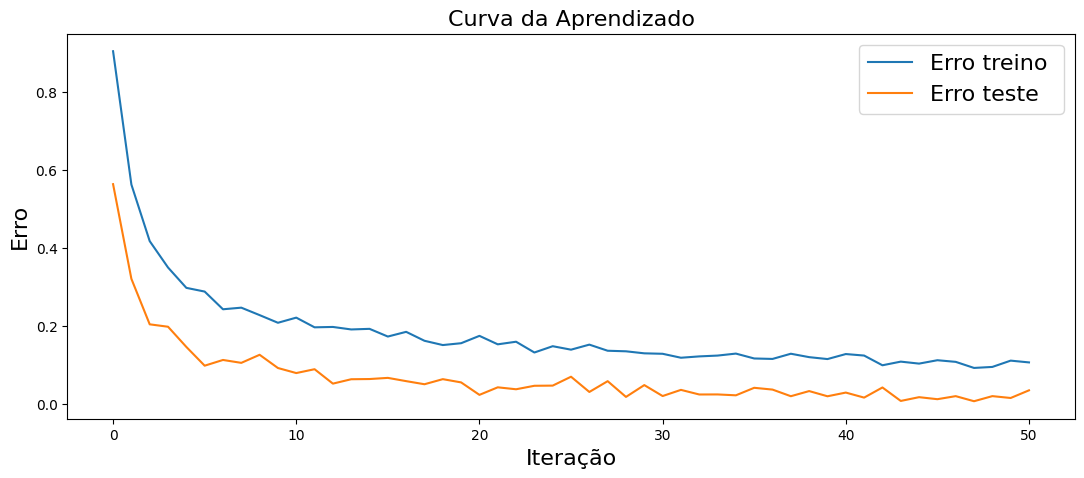

In [125]:
errors = {"Erro treino ": train_costs, "Erro teste": test_costs}
LearningCurve(errors)

ACURÁCIA

In [126]:
Acuracy(convnet, test_loader)

Acurácia no conjunto de teste: 100.00%


PREVISÕES

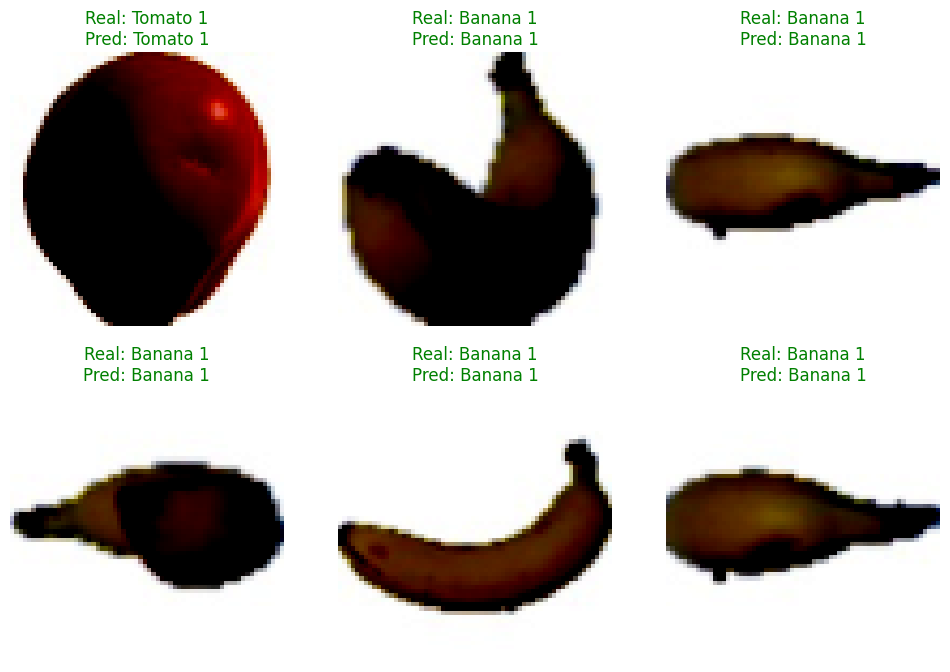

In [127]:
Predict(convnet, test_loader)

# CONTRUINDO UM MODELO RESNET

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" #definindo o dispositivo

resnet = models.resnet18(pretrained=True) #instancia o modelo resnet 18 pre treinado

n_features = resnet.fc.in_features #Numero de inputs de entrada da ultima da rede
resnet.fc = nn.Linear(n_features, 3)#Define a camada fc como uma camada linear
resnet = resnet.to(device)#aloca o modelo no dispositivo

loss_function = nn.CrossEntropyLoss()  # Definindo a fução de perda (Entropia Cruzada)
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)  # Definindo o otimizador (Adam)

# TREINAMENTO, MÉTRICAS E PREDIÇÕES PARA A RESNET

TREINAMENTO

In [129]:
epochs = 51 # numero de iteracoes
train_costs = [] # lista com o custo de treino para cada iteração
test_costs = [] # lista com o custo de teste para cada iteração
for t in range(epochs):
  '''Treina o modelo por 50 iterações e
  atualiza ambas as lista com seus respectivos valores '''
  train_cost = Train(resnet, train_loader, loss_function, optimizer)
  train_costs.append(train_cost)

  test_cost = Validate(resnet, test_loader, loss_function)
  test_costs.append(test_cost)

  if t % 10 == 0: print(f"Epoch: {t}; Train Loss: {train_cost}")

print("FIM")

Epoch: 0; Train Loss: 0.26669290020234054
Epoch: 10; Train Loss: 0.009894291289836273
Epoch: 20; Train Loss: 0.004186314654361922
Epoch: 30; Train Loss: 0.006097439332936321
Epoch: 40; Train Loss: 0.005681024708691338
Epoch: 50; Train Loss: 0.0010975487092663469
FIM


CURVA DE APRENDIZADO

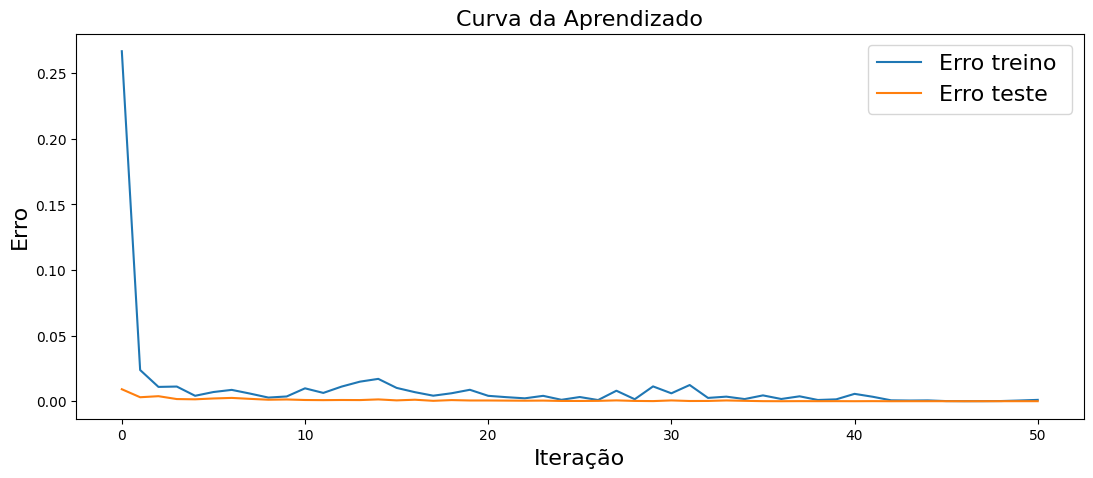

In [130]:
errors = {"Erro treino ": train_costs, "Erro teste": test_costs}
LearningCurve(errors)

ACURÁCIA

In [131]:
Acuracy(resnet, test_loader)

Acurácia no conjunto de teste: 100.00%


PREVISÕES

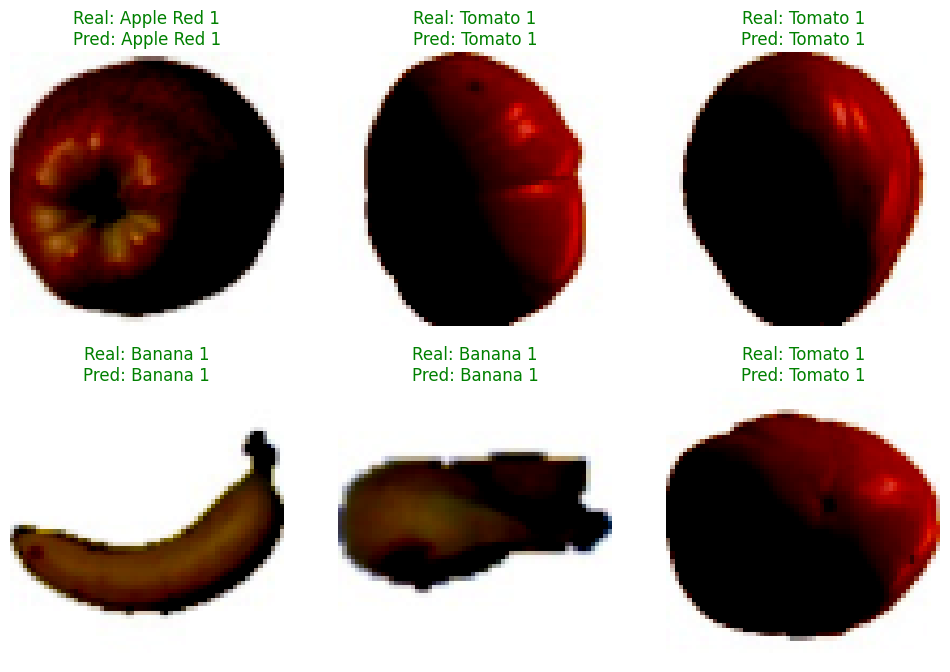

In [132]:
Predict(resnet, test_loader)